In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from math import sin, cos, sqrt, atan2, radians
from typing import List, Tuple, Any

from sklearn.cluster import MiniBatchKMeans

%matplotlib inline

### i. Creating the dataset
----

We'll start off by creating the dataset.

If you've run `make_sample_set.py` you should have a fairly decent sized CSV file to use for analysis.

The other "station" CSV file has latitude, longitude, and other features we'll use to enhance the bulk of the data.

In [2]:
seed = 33
row_limit = 3000000
data_dir = '../data/'

rides_use_columns = [
    'Duration', 'Start date', 'End date', 'Start station number', 'End station number', 'Member type'
]
dataset = pd.DataFrame()
for file in os.listdir(os.path.join(data_dir, 'rides')):
    if file.startswith('sample_set'):
        print(f'Reading in {file}...')
        tmp = pd.read_csv(
            os.path.join(data_dir, 'rides', file), 
            nrows=row_limit, 
            usecols=rides_use_columns
        )
        dataset = pd.concat([dataset, tmp], sort=False, ignore_index=True)

stations_use_columns = [
    'TERMINAL_NUMBER', 'LONGITUDE', 'LATITUDE', 'NUMBER_OF_EMPTY_DOCKS', 'NUMBER_OF_BIKES'
]
stations = pd.read_csv(
    os.path.join(data_dir, 'stations/Capital_Bike_Share_Locations.csv'),
    usecols=stations_use_columns
)

Reading in sample_set.csv...


In [3]:
print(f'Rides dataset (rows, columns): {dataset.shape}')

# dataset = dataset.loc[(dataset['Duration'] <= (60 * 60 * 1.5)), :]
# print(f' Dataset (rows, columns): {dataset.shape}')

Rides dataset (rows, columns): (3000000, 6)


In [4]:
print(f'Stations information (rows, columns): {stations.shape}')
stations.head(3)

Stations information (rows, columns): (571, 5)


,TERMINAL_NUMBER,LATITUDE,LONGITUDE,NUMBER_OF_BIKES,NUMBER_OF_EMPTY_DOCKS
0,32017,39.083673,-77.149162,7,8
1,32018,39.123513,-77.157410,7,7
2,32019,38.990249,-77.029350,2,13


In [5]:
stations.loc[:,'station_total_bikes'] = stations.loc[:,'NUMBER_OF_BIKES'] + stations.loc[:,'NUMBER_OF_EMPTY_DOCKS']
stations_start = stations.loc[:, ['station_total_bikes', 'LATITUDE', 'LONGITUDE', 'TERMINAL_NUMBER']]
stations_end = stations.loc[:, ['LATITUDE', 'LONGITUDE', 'TERMINAL_NUMBER']]

stations_start.columns = ['station_total_bikes', 'start_station_lat', 'start_station_long', 'Start station number']
stations_end.columns = ['end_station_lat', 'end_station_long', 'End station number']

stations_start.head(3)

,station_total_bikes,start_station_lat,start_station_long,Start station number
0,15,39.083673,-77.149162,32017
1,14,39.123513,-77.157410,32018
2,15,38.990249,-77.029350,32019


In [6]:
dataset = dataset.merge(stations_start, on='Start station number', sort=False)
dataset = dataset.merge(stations_end, on='End station number', sort=False)
dataset.head(3)

,Duration,Start date,End date,Start station number,End station number,Member type,station_total_bikes,start_station_lat,start_station_long,end_station_lat,end_station_long
0,1012,2010-09-20 11:27:04,2010-09-20 11:43:56,31208,31108,Member,16,38.8763,-77.0037,38.8767,-77.0178
1,369,2010-09-21 08:13:04,2010-09-21 08:19:13,31208,31108,Member,16,38.8763,-77.0037,38.8767,-77.0178
2,550,2010-09-26 15:40:16,2010-09-26 15:49:27,31208,31108,Member,16,38.8763,-77.0037,38.8767,-77.0178


## i. Exploratory Data Analysis

---

Now that the dataset has what we want, let's explore it!

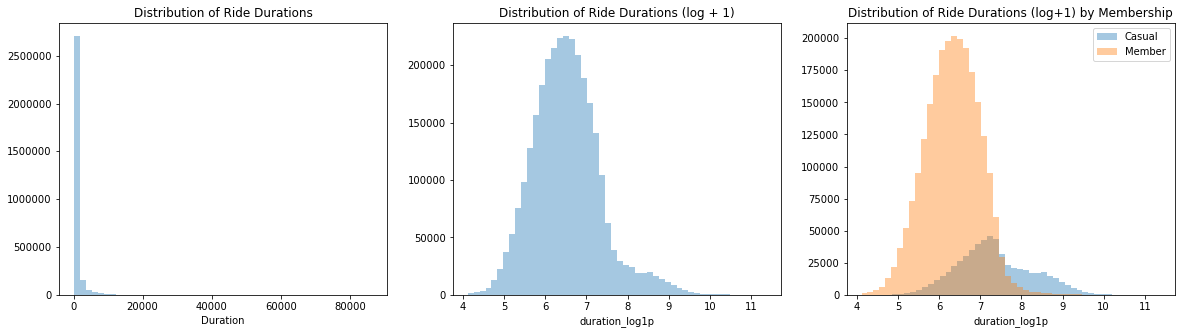

In [34]:
# Univariate analysis on target feature: "Duration"
plt.figure(figsize=(20,5));

plt.subplot(1,3,1);
sns.distplot(dataset['Duration'], bins=50, kde=False);
plt.title('Distribution of Ride Durations');

## heavily skewed target variable will be log1p transformed
dataset['duration_log1p'] = np.log1p(dataset['Duration'])

plt.subplot(1,3,2);
sns.distplot(dataset['duration_log1p'], bins=50, kde=False);
plt.title('Distribution of Ride Durations (log + 1)');

plt.subplot(1,3,3);
sns.distplot(dataset.loc[dataset['Member type'] == 'Casual', 'duration_log1p'], bins=50, label='Casual', kde=False);
sns.distplot(dataset.loc[dataset['Member type'] == 'Member', 'duration_log1p'], bins=50, label='Member', kde=False);
plt.legend();
plt.title('Distribution of Ride Durations (log+1) by Membership');

In [8]:
# The distribution above shows that are some very long rides skewing the data...
longest_ride = dataset['Duration'].max()
print(f'The longest ride was {round(longest_ride / 60, 2)} minutes or {round(longest_ride / 60 / 60, 2)} hours!')

The longest ride was 1439.68 minutes or 23.99 hours!


Outliers like these will impact model performance. This is definitely something that will need to be addressed,
however, it's not fair to just throw away or discard valid data. For example, let's say we were using a dataset 
of pro football players with features "weight" and "height". If a player in the dataset had a weight of something
like 45 lbs or a height of 2'7 then discarding that data would be justified as these values are not possible  
for an adult let alone a professional athlete. In our situation, however, it is possible that the rider may
have checked out a bike, rode it home, parked it outside their home or apartment and then returned it the next day.

Luckily, 

In [9]:
# 

##### Time features and Member type
The next few graphs will take a look at how time features relate to the ride duration. Also since we have a categorical field, "Member type", we'll compare those categories as well.

In [10]:
# Convert Start date and End date to "datetime" type
dataset['Start date'] = pd.to_datetime(dataset['Start date'])
dataset['End date'] = pd.to_datetime(dataset['End date'])

# Create separate "time" features
dataset['week_of_year'] = dataset['Start date'].apply(lambda x: x.weekofyear)
dataset['day_of_week'] = dataset['Start date'].apply(lambda x: x.dayofweek)
dataset['month'] = dataset['Start date'].apply(lambda x: x.month)
dataset['minute'] = dataset['Start date'].apply(lambda x: x.minute)
dataset['hour'] = dataset['Start date'].apply(lambda x: x.hour)

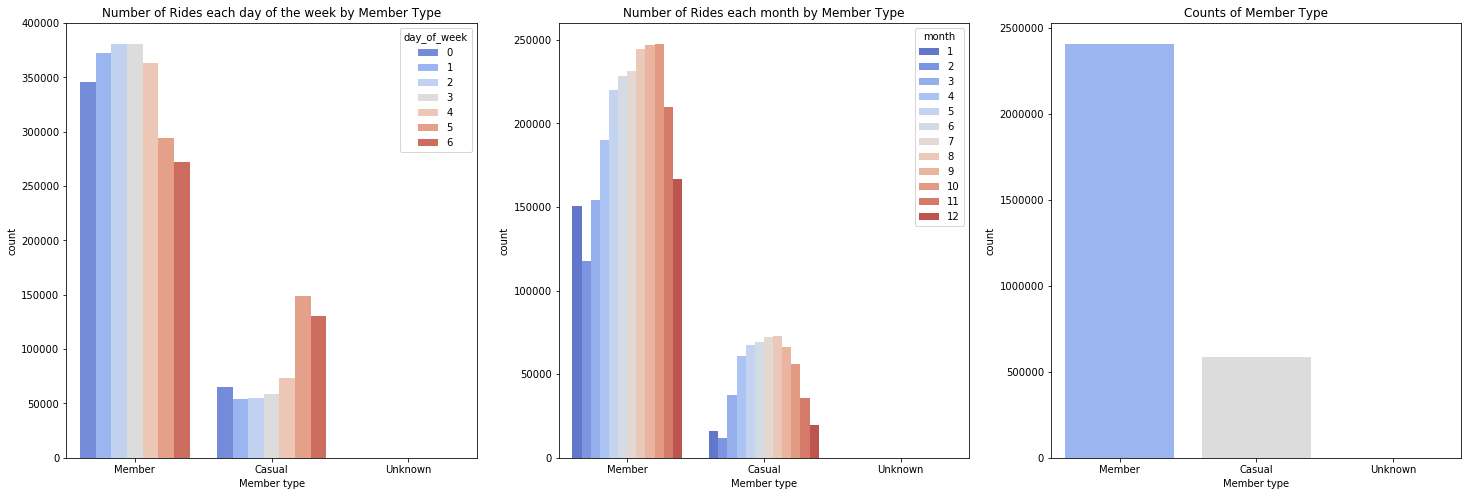

In [40]:
plt.figure(figsize=(25,8));

plt.subplot(1,3,1);
sns.countplot(x='Member type', hue='day_of_week', data=dataset, palette='coolwarm');
plt.title('Number of Rides each day of the week by Member Type');

plt.subplot(1,3,2);
sns.countplot(x='Member type', hue='month', data=dataset, palette='coolwarm');
plt.title('Number of Rides each month by Member Type');

plt.subplot(1,3,3);
sns.countplot(x='Member type', data=dataset, palette='coolwarm');
plt.title('Counts of Member Type');

Casual rides happen heavily on the weekends, whereas, riders using the Members plan tend to ride more during the week. Perhaps, buying the membership for the week when things aren't crowded makes more sense than a Casual pass? And/or buying a Casual pass on the weekend makes more sense than a Member pass because things are crowded or the individuals' are only planning on riding for the day?

Not sure what Member type "Unknown" is... I probably will remove it.

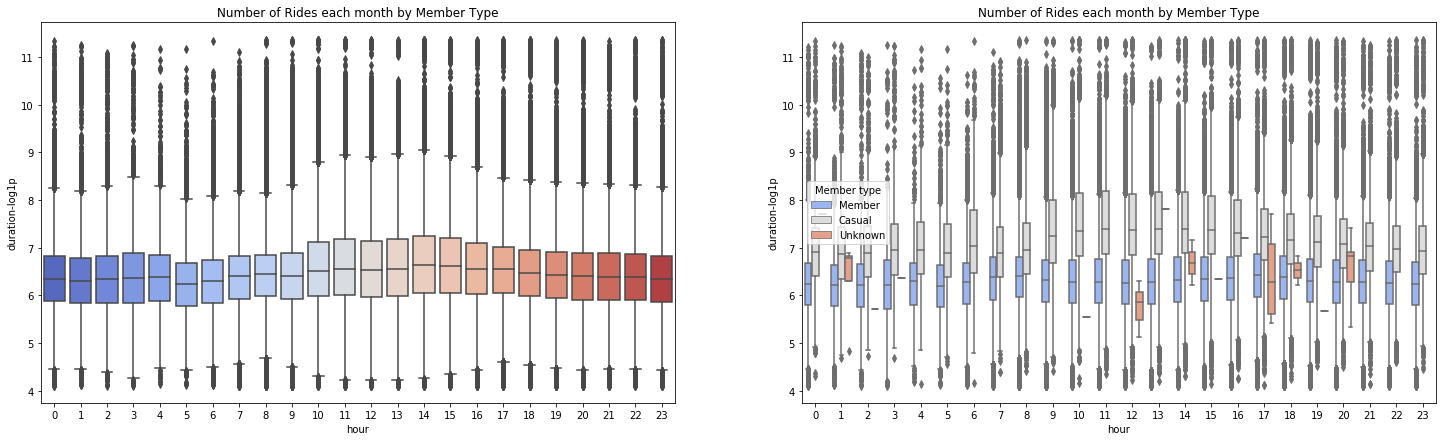

In [12]:
plt.figure(figsize=(25,7));

plt.subplot(1,2,1);
sns.boxplot(x='hour', y='duration-log1p', data=dataset, palette='coolwarm');
plt.title('Number of Rides each month by Member Type');

plt.subplot(1,2,2);
sns.boxplot(x='hour', y='duration-log1p', hue='Member type', data=dataset, palette='coolwarm');
plt.title('Number of Rides each month by Member Type');

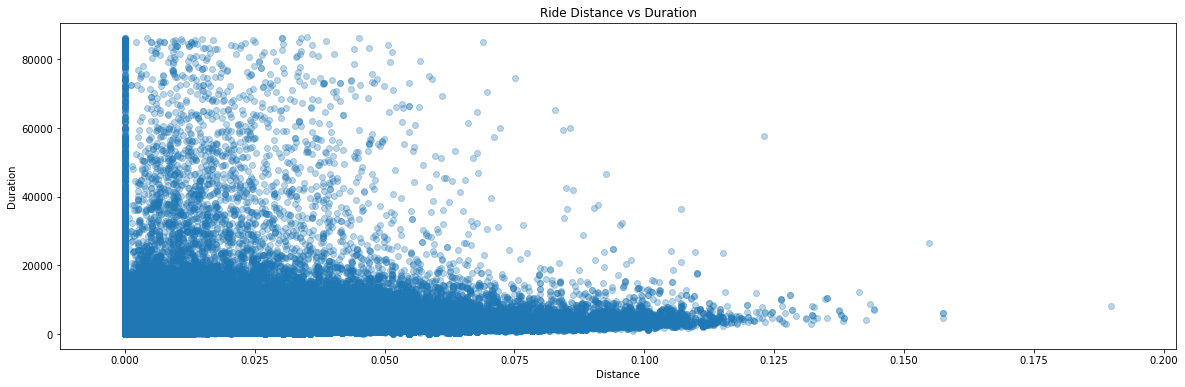

In [31]:
dataset['euclidian_distance'] = np.sqrt((dataset['start_station_lat'] - dataset['end_station_lat'])**2 + 
                                       (dataset['start_station_long'] - dataset['end_station_long'])**2)

plt.figure(figsize=(20,6));
plt.scatter(x='euclidian_distance', y='Duration', data=dataset, alpha=0.3);
plt.title('Ride Distance vs Duration');
plt.xlabel('Distance');
plt.ylabel('Duration');

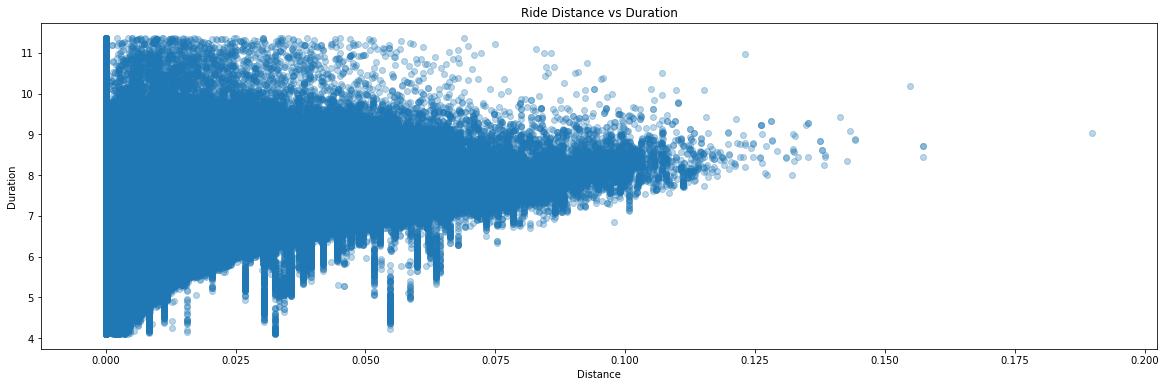

In [32]:
plt.figure(figsize=(20,6));
plt.scatter(x='euclidian_distance', y='duration_log1p', data=dataset, alpha=0.3);
plt.title('Ride Distance vs Duration (log + 1)');
plt.xlabel('Distance');
plt.ylabel('Duration (log + 1)');

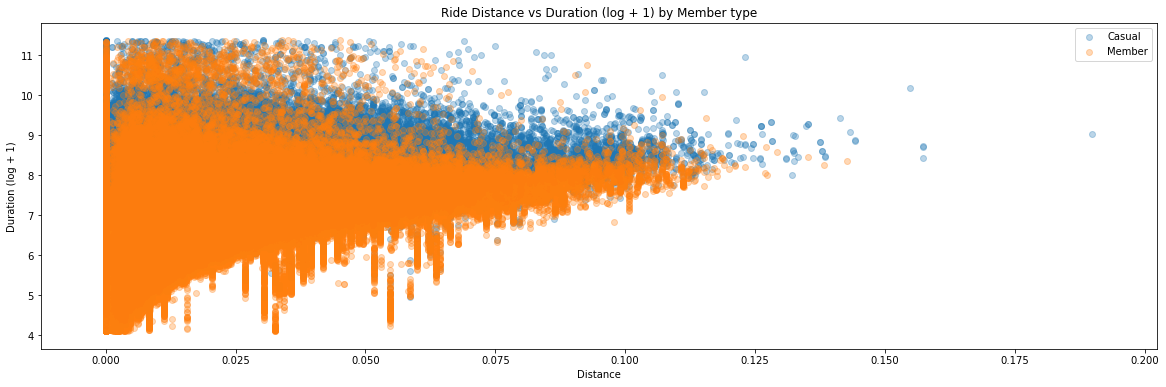

In [36]:
plt.figure(figsize=(20,6));
plt.scatter(
    x='euclidian_distance', 
    y='duration_log1p', 
    data=dataset.loc[dataset['Member type'] == 'Casual',:], 
    alpha=0.3,
    label='Casual'
);
plt.scatter(
    x='euclidian_distance', 
    y='duration_log1p', 
    data=dataset.loc[dataset['Member type'] == 'Member',:], 
    alpha=0.3,
    label='Member'
);

plt.title('Ride Distance vs Duration (log + 1) by Member type');
plt.xlabel('Distance');
plt.ylabel('Duration (log + 1)');
plt.legend();

As expected with bike sharing, a longer ride duration doesn't necessarily mean a longer ride distance wise, because
unlike an uber ride, bike riders can always return to the station where they started as one "trip". 

Also, "Casual" riders are taking longer rides than "Member" riders

In [43]:
mems_same_station = dataset.loc[(dataset['Member type'] == 'Member') & (dataset['Start station number'] == dataset['End station number']), :].shape[0]
cas_same_station = dataset.loc[(dataset['Member type'] == 'Casual') & (dataset['Start station number'] == dataset['End station number']), :].shape[0]

print(f'[{mems_same_station}] Member riders started and ended at the same station.')
print(f'[{cas_same_station}] Casual riders started and ended at the same station.')

[39829] Member riders started and ended at the same station.
[68450] Casual riders started and ended at the same station.


Even though in total there are almost 4x as many "Member" riders than "Casual" riders, the "Casual" riders overwhelmingly tend to start and stop at the same station number. This sounds reasonable - maybe "Casual" riders are less familiar with the area.

##### What is a Typical Ride with Capital BikeShare?

So far we've seen that Casual and Member riders are using bike sharing differently, but what else can the dataset tell us? Let's see if we can identify any deeper differences or similiarities there are between rides.

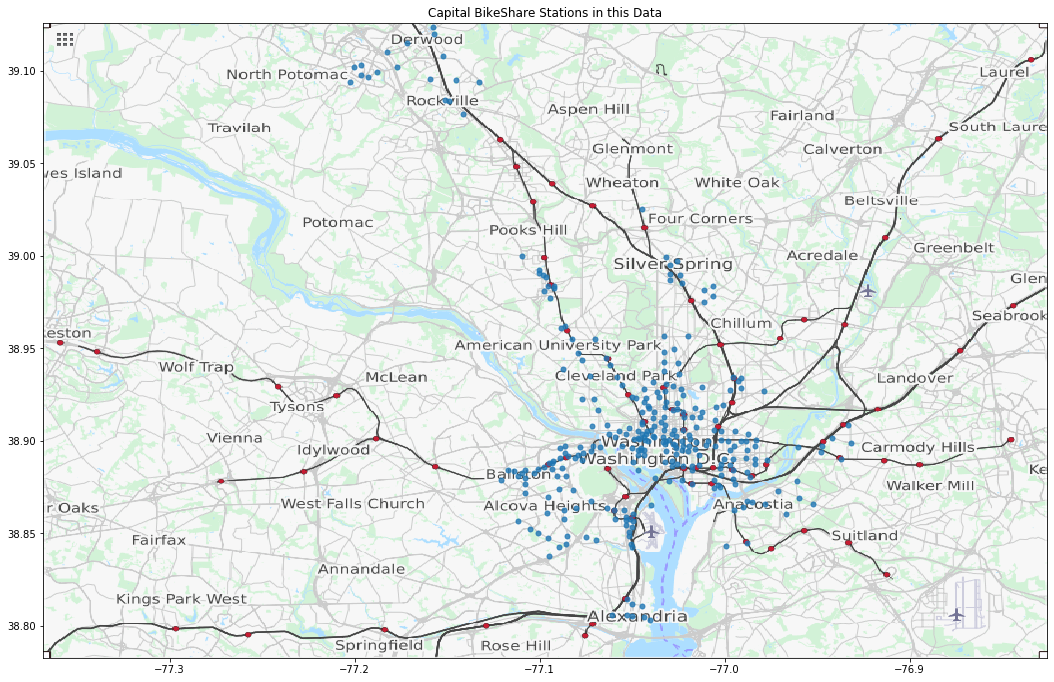

In [44]:
station_num_coords = dataset.groupby('Start station number')[['start_station_lat', 'start_station_long']].first()

BBox = (
    stations_start.start_station_long.min(),
    stations_start.start_station_long.max(),      
    stations_start.start_station_lat.min(),
    stations_start.start_station_lat.max()
)
        
cbdc = plt.imread('../data/img/area.png')

fig, ax = plt.subplots(figsize=(18,13));
ax.scatter(x=station_num_coords.start_station_long, y=station_num_coords.start_station_lat, zorder=1, alpha=0.8, s=25)
ax.set_title('Capital BikeShare Stations in this Dataset')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(cbdc, zorder=0, extent=BBox, aspect='equal');

In [45]:
ride_attr_columns = ['start_station_lat', 'start_station_long', 'end_station_lat', 'end_station_long', 'Duration']
ride_attributes = dataset.loc[:, ride_attr_columns].values

ride_means = ride_attributes.mean(axis=0)
ride_std = ride_attributes.std(axis=0)
ride_attributes = stats.zscore(ride_attributes, axis=0)

num_clusters = 80
ride_clusters = MiniBatchKMeans(n_clusters=num_clusters, batch_size=200000, n_init=100, random_state=seed)
cluster_inds = ride_clusters.fit_predict(ride_attributes)

In [46]:
cluster_total_counts, _ = np.histogram(cluster_inds, bins=num_clusters)
sorted_cluster_inds = np.flipud(np.argsort(cluster_total_counts))

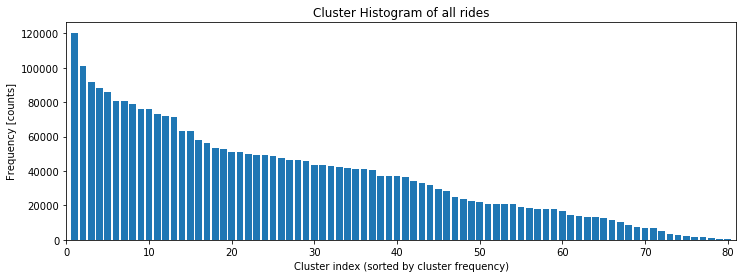

In [47]:
plt.figure(figsize=(12,4)); 
plt.title('Cluster Histogram of all rides');
plt.bar(range(1,num_clusters+1), cluster_total_counts[sorted_cluster_inds]);
plt.ylabel('Frequency [counts]'); plt.xlabel('Cluster index (sorted by cluster frequency)');
plt.xlim(0,num_clusters+1);

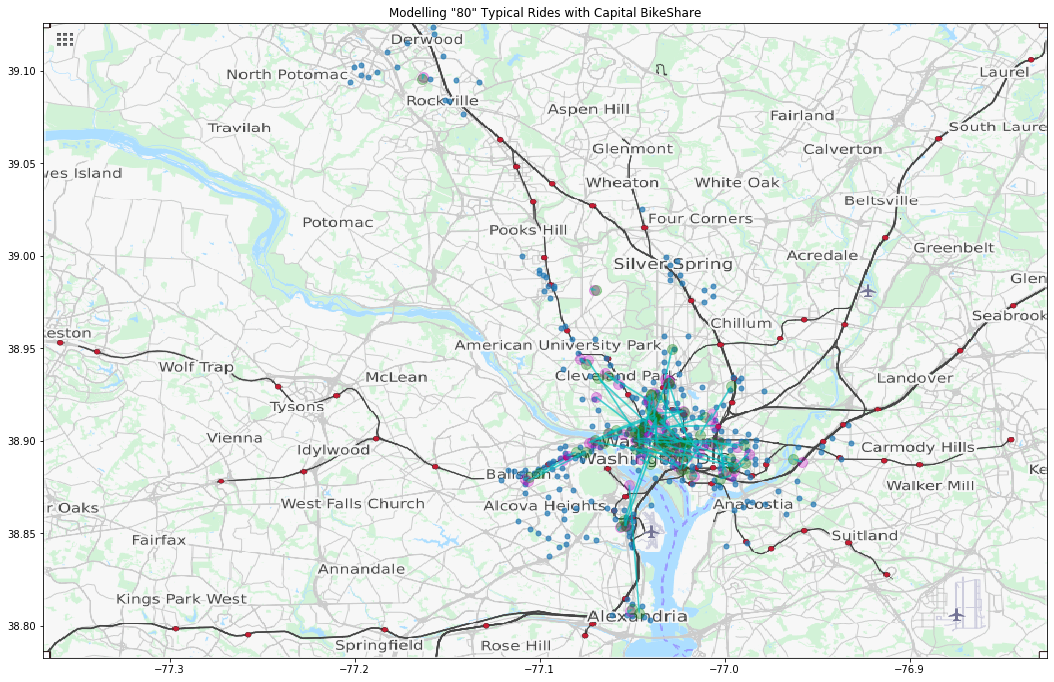

In [53]:
template_rides = ride_clusters.cluster_centers_ * np.tile(ride_std,(num_clusters,1)) + np.tile(ride_means,(num_clusters,1))

src_coords = template_rides[:, :2]
dst_coords = template_rides[:, 2:4]

fig, ax = plt.subplots(figsize=(18,13));
ax.scatter(x=station_num_coords.start_station_long, y=station_num_coords.start_station_lat, zorder=1, alpha=0.7, s=25)
ax.scatter(src_coords[:,1], src_coords[:,0], zorder=1, c='m', s=100, alpha=0.3)
ax.scatter(dst_coords[:,1], dst_coords[:,0], c='g', s=100, alpha=0.3)
ax.set_title(f'Modelling "{num_clusters}" Typical Rides with Capital BikeShare')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(cbdc, zorder=0, extent=BBox, aspect='equal');

for i in range(len(src_coords[:,0])):
    plt.arrow(
        src_coords[:,1][i], 
        src_coords[:,0][i], 
        dst_coords[:,1][i]-src_coords[:,1][i], 
        dst_coords[:,0][i]-src_coords[:,0][i], 
        edgecolor='c', 
        facecolor='c', 
        width=0.0005, 
        alpha=0.5, 
        head_width=0.001, 
        head_length=0.003, 
        length_includes_head=True
    )

As expected, a majority of rides happen within downtown DC where most stations are located.

One ride path that stuck out to me was the one between Alexandria and just below DC. Sure enough, after a quick
Google search I found: https://www.mountvernon.org/plan-your-visit/directions-parking-transportation/visit-mount-vernon-by-bike/

^ tl;dr - There's an 18 mile, paved bike route from DC to George Washington's Mount Vernon estate in Alexendria. Very cool!

One final observation, stations like those in Silver Spring and Rockville seem almost "cutoff" from the other stations closer to DC. I didn't really investigate single bike usage, but I'd bet that bikes in these areas almost exclusively stay in these areas for their lifetime.

In [ ]:
### more to come